In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

In [2]:
train_dir = 'train'
test_dir = 'test'
sample_submission = pd.read_csv('model/sample_submission.csv')

In [3]:
SPECIES = ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 
           'Apple Red Delicious', 'Avocado', 'Banana', 'Banana Lady Finger', 'Carambula', 
           'Corn', 'Corn Husk', 'Eggplant', 'Grape Blue', 'Grape Pink', 'Grape White', 
           'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Kiwi', 
           'Lemon', 'Limes', 'Lychee', 'Mango', 'Mango Red', 'Mangostan', 'Orange', 'Papaya', 
           'Passion Fruit', 'Peach', 'Peach 2', 'Pear', 'Pear Monster', 'Pepper Green', 
           'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 'Pineapple',
           'Pitahaya Red', 'Pomegranate', 'Rambutan', 'Salak', 'Strawberry',
           'Tamarillo', 'Tangelo', 'Tomato 4', 'Tomato not Ripened', 'Tomato Yellow', 'Watermelon']

for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))

Apple Braeburn 492 images
Apple Crimson Snow 444 images
Apple Red 1 492 images
Apple Red 2 492 images
Apple Red 3 429 images
Apple Red Delicious 490 images
Avocado 427 images
Banana 490 images
Banana Lady Finger 450 images
Carambula 490 images
Corn 450 images
Corn Husk 462 images
Eggplant 468 images
Grape Blue 984 images
Grape Pink 492 images
Grape White 490 images
Grape White 2 490 images
Grapefruit Pink 490 images
Grapefruit White 492 images
Guava 490 images
Kiwi 466 images
Lemon 492 images
Limes 490 images
Lychee 490 images
Mango 490 images
Mango Red 426 images
Mangostan 300 images
Orange 479 images
Papaya 492 images
Passion Fruit 490 images
Peach 492 images
Peach 2 738 images
Pear 492 images
Pear Monster 490 images
Pepper Green 444 images
Pepper Orange 702 images
Pepper Red 666 images
Pepper Yellow 666 images
Pineapple 490 images
Pitahaya Red 490 images
Pomegranate 492 images
Rambutan 492 images
Salak 490 images
Strawberry 492 images
Tamarillo 490 images
Tangelo 490 images
Tomato 4

In [4]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)

Training Data:  (25122, 3)


In [5]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [6]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(100,100))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(100,100,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

Wall time: 1min 4s


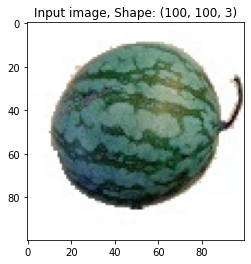

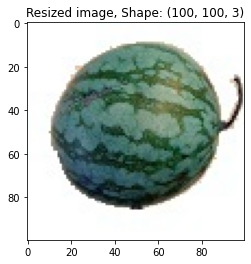

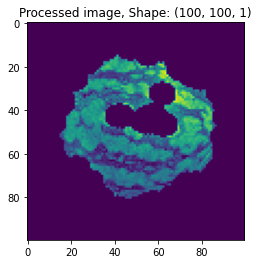

In [7]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(100,100)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [8]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)

In [10]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (100, 100, 4)


In [11]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(SPECIES), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 16)   1616        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 48, 48, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 16)   2320        leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [12]:

%%time

test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['test/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(100,100))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(100,100,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)

                            file
0    test/Apple Braeburn (1).jpg
1   test/Apple Braeburn (10).jpg
2  test/Apple Braeburn (100).jpg
3  test/Apple Braeburn (101).jpg
4  test/Apple Braeburn (102).jpg
Wall time: 21.4 s


In [13]:
model_feat = Model(inputs=model_new.input,outputs=model_new.get_layer('dense').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(22609, 512)
(2513, 512)
(8421, 512)


In [14]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [15]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.9511698880976602

In [16]:
svm.score(feat_val,np.argmax(y_val,axis=1))

0.9466772781536013

In [17]:
Pred_labels = svm.predict(feat_test)

In [19]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 
print(submission.head())

submission.to_csv('submission_svm_linear.csv', index=False)

                       file         species
0    Apple Braeburn (1).jpg  Apple Braeburn
1   Apple Braeburn (10).jpg  Apple Braeburn
2  Apple Braeburn (100).jpg           Peach
3  Apple Braeburn (101).jpg          Orange
4  Apple Braeburn (102).jpg     Apple Red 1


In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')


fitting done !!!


In [21]:
knn.score(feat_train,np.argmax(y_train,axis=1))

0.99575390331284

In [22]:
knn.score(feat_val,np.argmax(y_val,axis=1))

0.9844807003581377

In [23]:
knn_Pred_labels = knn.predict(feat_test)

In [24]:
knn_Pred_labels = pd.DataFrame(knn_Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = knn_Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in knn_Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 
print(submission.head())

submission.to_csv('submission_knn.csv', index=False)

                       file         species
0    Apple Braeburn (1).jpg  Apple Braeburn
1   Apple Braeburn (10).jpg  Apple Braeburn
2  Apple Braeburn (100).jpg          Orange
3  Apple Braeburn (101).jpg          Orange
4  Apple Braeburn (102).jpg          Orange


In [25]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [26]:
dtree.score(feat_train,np.argmax(y_train,axis=1))

1.0

In [27]:
dtree.score(feat_val,np.argmax(y_val,axis=1))

0.810982888977318

In [28]:
dtree_Pred_labels = dtree.predict(feat_test)

In [29]:
dtree_Pred_labels = pd.DataFrame(dtree_Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = dtree_Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in dtree_Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 
print(submission.head())

submission.to_csv('submission_dtree.csv', index=False)

                       file         species
0    Apple Braeburn (1).jpg  Apple Braeburn
1   Apple Braeburn (10).jpg  Apple Braeburn
2  Apple Braeburn (100).jpg  Apple Braeburn
3  Apple Braeburn (101).jpg  Apple Braeburn
4  Apple Braeburn (102).jpg          Orange
